In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as matplotlib
import cmocean
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

In [2]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S11_switch_mapping'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S11_switch_mapping
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S11_switch_mapping/parameter_set.csv


In [3]:
activation_rate = 45
deactivation_rate = 10
total_conc_0 = 400
diss_const_activation = 50
diss_const_deactivation = 50
frac_init = 0.75
conc_init = frac_init * total_conc_0
dt=0.001
v_min = 0.0
v_max = 0.5
colormap = "viridis"

pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

colors = [blue, pinkish_red, green, yellow, light_blue]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [blue, pinkish_red])
matplotlib.cm.register_cmap("mycolormap", cmap)

list_of_KD_act_deact = [5,50, 100, 150]
list_of_total_conc = np.arange(380, 421, 20)
list_of_total_conc_longer = np.arange(380, 421, 2)

list_of_volumes = np.arange(v_min, v_max, dt)
list_of_activation_rates = [40, 45, 50] #np.arange(7000, 9000, 100).tolist() #
list_of_activation_rates_longer = np.arange(40, 51, 0.1)

# Active concentration as a function of the volume for different total concentrations

In [4]:
def calculate_active_frac(volume, total_conc, diss_const_activation, diss_const_deactivation, activation_rate):
    a = activation_rate * volume - deactivation_rate
    b = deactivation_rate * (1 + diss_const_activation / total_conc) \
        - activation_rate * volume * (1 - diss_const_deactivation / total_conc)
    c = - activation_rate * volume * diss_const_deactivation / total_conc
    return (-b + np.sqrt(b**2 - 4 * a * c))/(2 * a)

def calculate_v_init(total_conc, diss_const_activation, diss_const_deactivation, activation_rate):
    return deactivation_rate / activation_rate * conc_init * (diss_const_activation + total_conc - conc_init) / \
           ((total_conc - conc_init) * (diss_const_deactivation + conc_init))

def calculate_v_init_from_frac(total_conc, diss_const_activation, diss_const_deactivation, activation_rate):
    return deactivation_rate / activation_rate * frac_init * (diss_const_activation / total_conc + 1 - frac_init) / \
           ((1 - frac_init) * (diss_const_deactivation/ total_conc + frac_init))

## Make dataframe

In [5]:
def generate_dict_frac(volume, active_conc, active_frac, total_conc, KD_act, KD_inact):
    return {
        "volume": volume,
        "active_conc": active_conc,
        "active_frac": active_frac,
        "total_conc": total_conc,
        "KD_act": KD_act,
        "KD_inact": KD_inact
    }

def generate_data_frame_frac():
    dictionary_list = []
    for KD in list_of_KD_act_deact:
        for total_conc in list_of_total_conc:
            for volume in list_of_volumes:
                active_frac = calculate_active_frac(volume, total_conc, KD, KD, activation_rate)
                dictionary = generate_dict_frac(volume, total_conc * active_frac, active_frac, 
                                           total_conc, KD, KD)
                dictionary_list.append(dictionary)
    return dictionary_list

def make_legend_total_conc_frac(total_conc):
    return r'$[D]_{{\rm T}}={}$  [$ \mu $m$^{{-3}}$]'.format(int(total_conc))

data_frame = pd.DataFrame(generate_data_frame_frac())
data_frame.loc[:, 'legend_total_conc'] = data_frame.apply(lambda row: make_legend_total_conc_frac(row.total_conc)
                                                          , axis = 1)
# data_frame

## Plot active fraction as a function of the volume

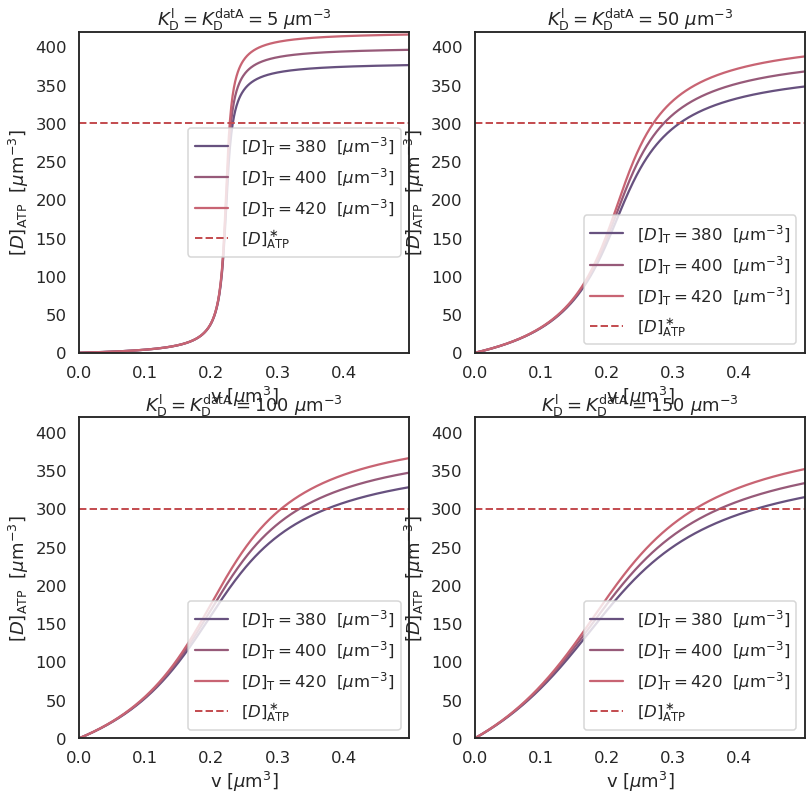

In [6]:
sns.set(style="white")
sns.set_context("talk")

fig, ax = plt.subplots(int(len(list_of_KD_act_deact)/2),int(len(list_of_KD_act_deact)/2),figsize=(13,13))
indx =0 
for row in range(0,len(ax)):
    for column in range(len(ax[row])):
        cpal = sns.color_palette("mycolormap", n_colors=len(list_of_total_conc))
        sns.lineplot(
            x='volume',
            y='active_conc', 
    #         data=data_frame.sort_values(by=["legend_total_conc"]),
            data=data_frame.loc[data_frame['KD_act'] == list_of_KD_act_deact[indx]],
            hue= 'legend_total_conc',
            palette= cpal, #sns.color_palette("cmo.thermal", n_colors=len(list_of_total_conc)), 
            hue_norm=matplotlib.colors.LogNorm(),
            ax=ax[row,column]
        );
        ax[row,column].axhline(y=conc_init, color='r', linestyle='--', lw=2, label=r'$[D]_{\rm ATP}^\ast$')
        ax[row,column].margins(0)
        ax[row,column].set(ylim=(0,420))
        ax[row,column].set(xlabel=r'v [$\mu$m$^3$]', ylabel=r'$[D]_{\rm ATP}$  [$ \mu $m$^{{-3}}$]')
        handles, labels = ax[row,column].get_legend_handles_labels()
        ax[row,column].legend(handles=handles[1:], labels=labels[1:])
        ax[row,column].set_title(r'$K_{{\rm D}}^{{\rm l}} = K_{{\rm D}}^{{\rm datA}}={}$ $ \mu $m$^{{-3}}$'.format(list_of_KD_act_deact[indx]))
        indx=indx +1
plt.savefig(file_path + '/vary_total_crit_conc.pdf', format='pdf')

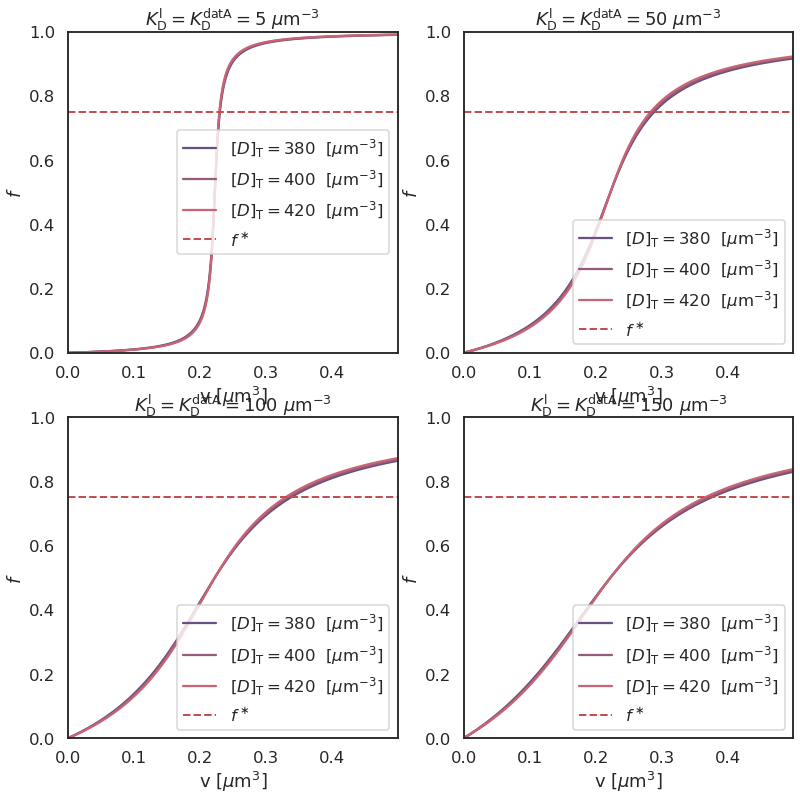

In [7]:
sns.set(style="white")
sns.set_context("talk")

fig, ax = plt.subplots(int(len(list_of_KD_act_deact)/2),int(len(list_of_KD_act_deact)/2),figsize=(13,13))
indx =0 
for row in range(0,len(ax)):
    for column in range(len(ax[row])):
        sns.lineplot(
            x='volume',
            y='active_frac', 
    #         data=data_frame.sort_values(by=["legend_total_conc"]),
            data=data_frame.loc[data_frame['KD_act'] == list_of_KD_act_deact[indx]],
            hue= 'legend_total_conc',
            palette= sns.color_palette("mycolormap", n_colors=len(list_of_total_conc)), 
            hue_norm=matplotlib.colors.LogNorm(),
            ax=ax[row,column]
        );
        ax[row,column].axhline(y=frac_init, color='r', linestyle='--', lw=2, label=r'$f^\ast$')
        ax[row,column].set(xlabel=r'v [$\mu$m$^3$]', ylabel=r'$f$')
        ax[row,column].margins(0)
        ax[row,column].set(ylim=(0,1))
        handles, labels = ax[row,column].get_legend_handles_labels()
        ax[row,column].legend(handles=handles[1:], labels=labels[1:])
        ax[row,column].set_title(r'$K_{{\rm D}}^{{\rm l}} = K_{{\rm D}}^{{\rm datA}}={}$ $ \mu $m$^{{-3}}$'.format(list_of_KD_act_deact[indx]))
        indx=indx +1
plt.savefig(file_path + '/vary_total_crit_frac.pdf', format='pdf')

# Initiation volume as function of total concentration for different dissociation constants

In [8]:
def generate_dict2(total_conc, v_init_crit_conc, v_init_crit_frac, KD_act, KD_inact):
    return {
        "total_conc": total_conc,
        "v_init_crit_conc": v_init_crit_conc,
        "v_init_crit_frac": v_init_crit_frac,
        "KD_act": KD_act,
        "KD_inact": KD_inact
    }

def generate_data_frame2():
    dictionary_list = []
    for KD_act_deact in list_of_KD_act_deact:
        for total_conc in list_of_total_conc_longer:
            v_init_crit_conc = calculate_v_init(total_conc, KD_act_deact, KD_act_deact, activation_rate)
            v_init_crit_frac = calculate_v_init_from_frac(total_conc, KD_act_deact, KD_act_deact, activation_rate)
            dictionary = generate_dict2(total_conc, v_init_crit_conc, v_init_crit_frac, KD_act_deact, KD_act_deact)
            dictionary_list.append(dictionary)
    return dictionary_list

def make_legend_KD(KD):
    return r'$K_{{\rm D}}^{{\rm l}} = K_{{\rm D}}^{{\rm datA}}={}$ $ \mu $m$^{{-3}}$'.format(int(KD))

data_frame2 = pd.DataFrame(generate_data_frame2())
data_frame2.loc[:, 'legend_KD'] = data_frame2.apply(lambda row: make_legend_KD(row.KD_act), axis = 1)

## Plot initiation volume at critical concentration

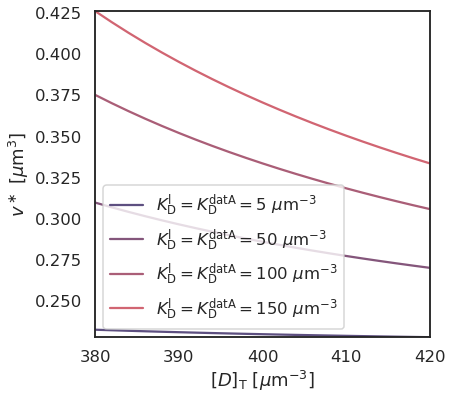

In [9]:
sns.set(style="white")
sns.set_context("talk")
sns.color_palette("rocket")

fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(
    x='total_conc',
    y='v_init_crit_conc', 
    data=data_frame2.sort_values(by=["KD_act"]),
    hue= 'legend_KD',
    palette=sns.color_palette("mycolormap", n_colors=len(list_of_KD_act_deact)), 
    hue_norm=matplotlib.colors.LogNorm(),
    ax=ax
);
# ax.axhline(y=conc_init, xmin=0, xmax=v_max, color='r', linestyle='--', lw=2, label=r'$[D]_{\rm ATP}^\ast$')
ax.set(xlabel=r'$[D]_{\rm T}$ [$ \mu $m$^{{-3}}$]', ylabel=r'$v^\ast$ [$\mu$m$^3$]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
# ax.set(ylim=(0.2, 0.35))
ax.margins(0)
plt.savefig(file_path + '/mapping_total_crit_conc.pdf', format='pdf', bbox_inches='tight')

## Plot initiation volume at critical fraction

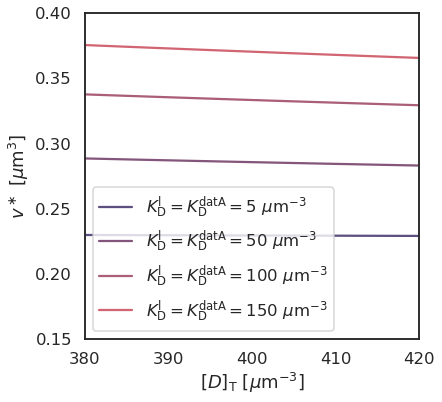

In [10]:
sns.set(style="white")
sns.set_context("talk")
sns.color_palette("rocket")

fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(
    x='total_conc',
    y='v_init_crit_frac', 
    data=data_frame2.sort_values(by=["KD_act"]),
    hue= 'legend_KD',
    palette= sns.color_palette("mycolormap", n_colors=len(list_of_KD_act_deact)),
    hue_norm=matplotlib.colors.LogNorm(),
    ax=ax
);
# ax.axhline(y=conc_init, xmin=0, xmax=v_max, color='r', linestyle='--', lw=2, label=r'$[D]_{\rm ATP}^\ast$')
ax.set(xlabel=r'$[D]_{\rm T}$ [$ \mu $m$^{{-3}}$]', ylabel=r'$v^\ast$ [$\mu$m$^3$]')
ax.set(ylim=(0.15, 0.4))
ax.margins(0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/mapping_total_crit_frac.pdf', format='pdf', bbox_inches='tight')

# Variation of active fraction with acidic phospholipids

## Make dataframe

In [11]:
def generate_dict_act_rate(volume, active_conc, active_frac, total_conc, KD_act, KD_inact, activation_rate):
    return {
        "volume": volume,
        "active_conc": active_conc,
        "active_frac": active_frac,
        "total_conc": total_conc,
        "KD_act": KD_act,
        "KD_inact": KD_inact,
        "activation_rate": activation_rate
    }

def generate_data_frame_frac_activation_rate():
    dictionary_list = []
    for KD in list_of_KD_act_deact:
        for activation_rate in list_of_activation_rates:
            for volume in list_of_volumes:
                active_frac = calculate_active_frac(volume, total_conc_0, KD, KD, activation_rate)
                dictionary = generate_dict_act_rate(volume, total_conc_0 * active_frac, active_frac, 
                                           total_conc_0, KD, KD, activation_rate)
                dictionary_list.append(dictionary)
    return dictionary_list

def make_legend_activation_rate_frac(activation_rate):
    return r'$\alpha_{{\rm l}}[l]={}$ [$\mu $m$^{{-3}} \,$ min$^{{-1}}$]'.format(int(activation_rate))

data_frame_act_rate = pd.DataFrame(generate_data_frame_frac_activation_rate())
data_frame_act_rate.loc[:, 'legend_activation_rate'] = data_frame_act_rate.apply(lambda row: make_legend_activation_rate_frac(row.activation_rate)
                                                          , axis = 1)

/home/berger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


## Fraction as function of volume

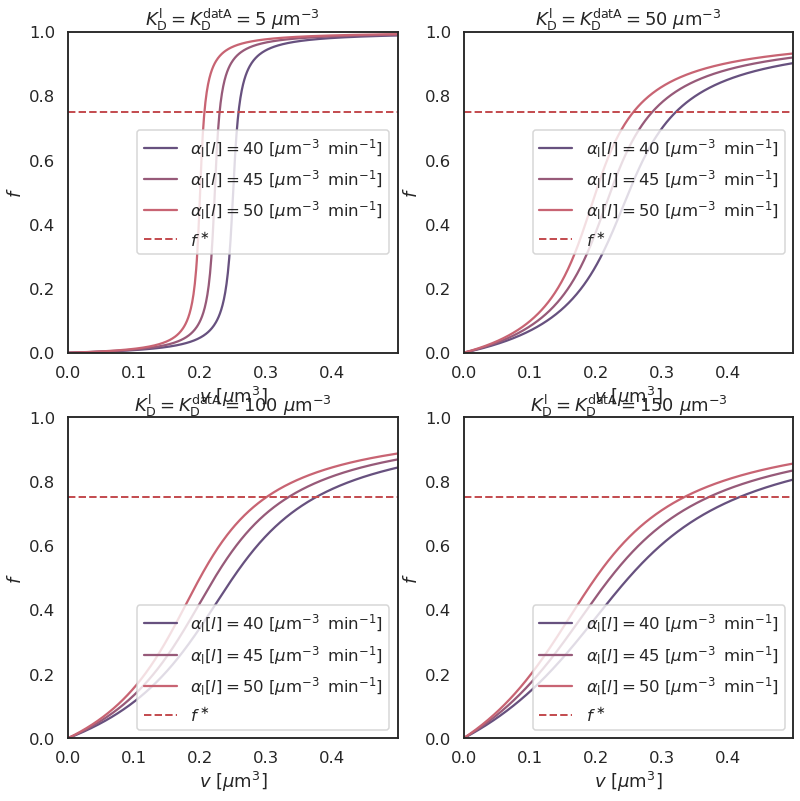

In [12]:
sns.set(style="white")
sns.set_context("talk")

fig, ax = plt.subplots(int(len(list_of_KD_act_deact)/2),int(len(list_of_KD_act_deact)/2),figsize=(13,13))
indx =0 
for row in range(0,len(ax)):
    for column in range(len(ax[row])):
        sns.lineplot(
            x='volume',
            y='active_frac', 
            data=data_frame_act_rate.loc[data_frame_act_rate['KD_act'] == list_of_KD_act_deact[indx]],
            hue= 'legend_activation_rate',
            palette=sns.color_palette("mycolormap", n_colors=len(list_of_activation_rates)),
            hue_norm=matplotlib.colors.LogNorm(),
            ax=ax[row,column]
        );
        ax[row,column].axhline(y=frac_init, color='r', linestyle='--', lw=2, label=r'$f^\ast$')
        ax[row,column].margins(0)
        ax[row,column].set(ylim=(0,1))
        ax[row,column].set(xlabel=r'$v$ [$\mu$m$^3$]', ylabel=r'$f$')
        ax[row, column].legend
        handles, labels = ax[row,column].get_legend_handles_labels()
        ax[row,column].legend(handles=handles[1:], labels=labels[1:])
        ax[row,column].set_title(r'$K_{{\rm D}}^{{\rm l}} = K_{{\rm D}}^{{\rm datA}}={}$ $ \mu $m$^{{-3}}$'.format(list_of_KD_act_deact[indx]))
        indx=indx +1
plt.savefig(file_path + '/vary_lipids_crit_frac.pdf', format='pdf')

# Initiation volume as function of total concentration for different dissociation constants

In [13]:
def generate_dict_act_rate(total_conc, v_init_crit_conc, v_init_crit_frac, KD_act, KD_inact, activation_rate):
    return {
        "total_conc": total_conc,
        "v_init_crit_conc": v_init_crit_conc,
        "v_init_crit_frac": v_init_crit_frac,
        "KD_act": KD_act,
        "KD_inact": KD_inact,
        "activation_rate": activation_rate
    }

def generate_data_frame_act_rate():
    dictionary_list = []
    for KD_act_deact in list_of_KD_act_deact:
        for activation_rate in list_of_activation_rates_longer:
            v_init_crit_conc = calculate_v_init(total_conc_0, KD_act_deact, KD_act_deact, activation_rate)
            v_init_crit_frac = calculate_v_init_from_frac(total_conc_0, KD_act_deact, KD_act_deact, activation_rate)
            dictionary = generate_dict_act_rate(total_conc_0, v_init_crit_conc, 
                                                v_init_crit_frac, KD_act_deact, KD_act_deact, activation_rate)
            dictionary_list.append(dictionary)
    return dictionary_list

def make_legend_KD(KD):
    return r'$K_{{\rm D}}^{{\rm l}} = K_{{\rm D}}^{{\rm datA}}={}$ $ \mu $m$^{{-3}}$'.format(int(KD))

data_frame_act_rate2 = pd.DataFrame(generate_data_frame_act_rate())
data_frame_act_rate2.loc[:, 'legend_KD'] = data_frame_act_rate2.apply(lambda row: make_legend_KD(row.KD_act), axis = 1)

## Plot initiation volume at critical fraction

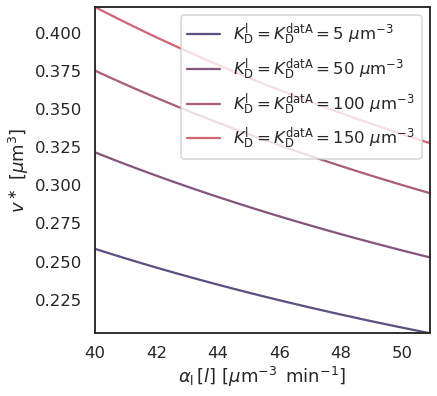

In [14]:
sns.set(style="white")
sns.set_context("talk")
sns.color_palette("rocket")

fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(
    x='activation_rate',
    y='v_init_crit_frac', 
    data=data_frame_act_rate2.sort_values(by=["KD_act"]),
#     data=data_frame_act_rate2[data_frame_act_rate2["KD_act"]==5],
    hue= 'legend_KD',
    palette= sns.color_palette("mycolormap", n_colors=len(list_of_KD_act_deact)),
    hue_norm=matplotlib.colors.LogNorm(),
    ax=ax
);
# ax.axhline(y=conc_init, xmin=0, xmax=v_max, color='r', linestyle='--', lw=2, label=r'$[D]_{\rm ATP}^\ast$')
ax.set(xlabel=r'$\alpha_{\rm l} \, [l]$ [$\mu $m$^{-3} \,$ min$^{-1}$]', ylabel=r'$v^\ast$ [$\mu$m$^3$]')
handles, labels = ax.get_legend_handles_labels()
# ax.set(ylim=(0.18, 0.43))
ax.margins(0)
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/mapping_lipids_crit_frac.pdf', format='pdf', bbox_inches='tight')